In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib
import math
from astropy import units as u
from astropy.modeling import models,fitting
from astropy.modeling import Model
from astropy.io import ascii
from astroquery.vizier import Vizier
import starkit
from starkit.fitkit.likelihoods import SpectralChi2Likelihood as Chi2Likelihood, SpectralL1Likelihood
from starkit.gridkit import load_grid
from starkit.fitkit.multinest.base import MultiNest, MultiNestResult
from starkit import assemble_model, operations
from starkit.fitkit import priors
from starkit.base.operations.spectrograph import (Interpolate, Normalize,
                                                  NormalizeParts,InstrumentConvolveGrating)
from starkit.base.operations.stellar import (RotationalBroadening, DopplerShift)
from starkit.fix_spectrum1d import SKSpectrum1D
from specutils import read_fits_file,plotlines
import numpy as np
import os,scipy
from specutils import Spectrum1D,rvmeasure
import datetime,glob
import model_tester_updated as mt
from matplotlib.backends.backend_pdf import PdfPages
import operator
import sys
from matplotlib.pyplot import cm
import multi_order_fitting_functions as mtf
from scipy.stats.stats import pearsonr, chisquare
from scipy.optimize import curve_fit
from scipy import ndimage as nd
import sl_response_plot_multiorder as slp
import scipy.stats


class Splitter3(Model):
    # split a single spectrum into 3
    inputs = ('w', 'f')
    outputs = ('w', 'f', 'w', 'f', 'w', 'f')

    def evaluate(self, w, f):
        return w, f, w, f, w, f


class Combiner3(Model):
    # combines the likelihood for four spectra
    inputs = ('l1', 'l2', 'l3')
    outputs = ('ltot',)

    def evaluate(self, l1, l2, l3):
        return l1 + l2 + l3
    
g = mtf.load_full_grid_bosz()

[starkit.gridkit.base][INFO   ]  Reading index (base.py:266)
[starkit.gridkit.base][INFO   ]  Discovered columns teff, logg, mh, alpha (base.py:269)
[starkit.gridkit.base][INFO   ]  Reading Fluxes (base.py:272)
[starkit.gridkit.base][INFO   ]  Fluxes shape (6790, 18233) (base.py:275)
[py.warnings         ][WARNING]  /u/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/astropy/units/format/generic.py:461: UnitsWarning: 'erg/s/angstrom' contains multiple slashes, which is discouraged by the FITS standard
  core.UnitsWarning)
 (generic.py:461)
[starkit.gridkit.base][INFO   ]  Initializing spec grid (base.py:309)
[starkit.gridkit.base][WARNING]  **** NO WAVELENGTH TYPE SET DEFAULTING TO GRID (vacuum) ****

 (base.py:75)


In [2]:
cal_star_info_all = list(scipy.genfromtxt('/u/rbentley/metallicity/cal_star_info.dat', delimiter='\t', skip_header=1, dtype=None))
cal_star_info_all.sort(key=lambda x: x[1])
cal_star_names = [x[0] for x in cal_star_info_all[:-1]]

snr=30.

plot_stars = ['NGC6791_J19205+3748282', 'NGC6819_J19411+4010517', 'M5 J15190+0208']

[py.warnings         ][WARNING]  /Network/Servers/galaxy1.astro.ucla.edu/volume1/GhezGroup/home-directories/rbentley/miniconda3/envs/starkit/lib/python2.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.
 (npyio.py:2068)


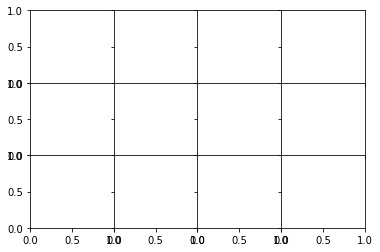

In [10]:
fig, axs = plt.subplots(3, 4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})

si1_ax, si2_ax, s1_ax = axs        

In [14]:
    for k in range(len(plot_stars)):
        starname = plot_stars[k]
        
        result = MultiNestResult.from_hdf5(
            '/u/rbentley/metallicity/spectra_fits/masked_fit_results/orders34-35-36/BOSZ_fits/unmasked/' + starname + '_order34-36_bosz_adderr.h5')
        
        file1 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order34*.dat')
        file2 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order35*.dat')
        file3 = glob.glob('/u/ghezgroup/data/metallicity/nirspec/spectra/' + starname + '_order36*.dat')

        starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='micron')
        starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='micron')
        starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='micron')

        waverange34 = [np.amin(starspectrum34.wavelength.value[:970]), np.amax(starspectrum34.wavelength.value[:970])]
        waverange35 = [np.amin(starspectrum35.wavelength.value[:970]), np.amax(starspectrum35.wavelength.value[:970])]
        waverange36 = [np.amin(starspectrum36.wavelength.value[:970]), np.amax(starspectrum36.wavelength.value[:970])]

        starspectrum34 = read_fits_file.read_nirspec_dat(file1, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange34)
        starspectrum35 = read_fits_file.read_nirspec_dat(file2, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange35)
        starspectrum36 = read_fits_file.read_nirspec_dat(file3, desired_wavelength_units='Angstrom',
                                                         wave_range=waverange36)

        starspectrum34.uncertainty = (np.zeros(len(starspectrum34.flux.value)) + 1.0 / np.float(
            snr)) * starspectrum34.flux.unit
        starspectrum35.uncertainty = (np.zeros(len(starspectrum35.flux.value)) + 1.0 / np.float(
            snr)) * starspectrum35.flux.unit
        starspectrum36.uncertainty = (np.zeros(len(starspectrum36.flux.value)) + 1.0 / np.float(
            snr)) * starspectrum36.flux.unit
        
        bmodel = slp.make_model_three_order(starspectrum34, starspectrum35, starspectrum36, g)
        
        
        w1, f1, w2, f2, w3, f3 = bmodel()


        cont34 = []
        for s in np.linspace(22400, 22750, 8):
            data_idx = np.where((w1 >= s) & (w1 <= s+50))[0]

            if (s+50 <= np.amax(w1)) & (s >= np.amin(w1)):

                cont34 += [(np.amax(f1[data_idx]), s,s+50)]

        cont35 = []
        for s in np.linspace(21750, 22100, 8):
            data_idx = np.where((w2 >= s) & (w2 <= s+50))[0]
            if (s+50 <= np.amax(w2)) & (s >= np.amin(w2)):

                cont35 += [(np.amax(f2[data_idx]), s,s+50)]

        cont36 = []
        for s in np.linspace(21150, 21500, 8):
            data_idx = np.where((w3 >= s) & (w3 <= s+50))[0]

            if (s+50 <= np.amax(w3)) & (s >= np.amin(w3)):

                cont36 += [(np.amax(f3[data_idx]), s,s+50)]


        b_si1_ew = rvmeasure.equivalent_width(w2, f2, specRange=[22076.5, 22080.5],
                                     continuum=cont35[4][0])  # Si line

        b_si2_ew = rvmeasure.equivalent_width(w3, f3, specRange=[21376.5, 21380.5],
                                     continuum=cont36[3][0])  # Si line
        b_s1_ew = rvmeasure.equivalent_width(w1, f1, specRange=[22511.5, 22516],
                                     continuum=cont34[1][0])  # S line


        d_w1 = starspectrum34.wavelength.value / (result.median['vrad_3'] / 3e5 + 1.0)
        d_w2 = starspectrum35.wavelength.value / (result.median['vrad_4'] / 3e5 + 1.0)
        d_w3 = starspectrum36.wavelength.value / (result.median['vrad_5'] / 3e5 + 1.0)


        d_si1_ew = rvmeasure.equivalent_width(d_w2, starspectrum35.flux.value, specRange=[22076.5, 22080.5],
                                         continuum=cont35[4][0])  # Si line

        d_si2_ew = rvmeasure.equivalent_width(d_w3, starspectrum36.flux.value, specRange=[21376.5, 21380.5],
                                         continuum=cont36[3][0])  # Si line
        d_s1_ew = rvmeasure.equivalent_width(d_w1, starspectrum34.flux.value, specRange=[22511.5, 22516],
                                         continuum=cont34[1][0])  # S line
        print k
        si1_ax[k].plot(d_w2, starspectrum35.flux.value)
        
    plt.show()
        

('clipping', [2.2449279, 2.2750347])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])
0
('clipping', [2.2403469, 2.2703373])
('clipping', [2.1811268, 2.2103229])
('clipping', [2.1168036, 2.1450112])
1
('clipping', [2.2413218, 2.2714481])
('clipping', [2.1776764, 2.2069016])
('clipping', [2.1176255, 2.1459301])
2


In [8]:
\